In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sc

In [414]:
data = pd.read_csv('diabetes.txt', sep = " ")

In [415]:
# This is the good data
data.shape

(442, 11)

In [416]:
# Define X and Y arrays
X = data.iloc[:,:data.shape[1]-1].as_matrix()
Y = data.iloc[:,data.shape[1]-1].ravel()

In [417]:
# We center the Y
Y_tilde = Y - Y.mean(axis=0)

## 1] CHOOSING THE BAYESIAN LASSO PARAMETER


The Gibbs sampler used here uses the following full conditional distributions:

- The full conditional for $\beta$ is:

<h3 align="center"> $\mathcal{N}_p(A^{-1}X^T\tilde{y}, \sigma^2A^{-1})$ where $A = X^TX+D^{-1}_\tau$ and $D_\tau = diag(\tau^2_1,...,\tau^2_p)$ </h3>

- The full conditional for $\sigma^2$ is:

<h3 align="center"> $\mathcal{I}nverse\mathcal{G}amma(\frac{n-1+p}{2}, \frac{(\tilde{y}-X\beta)^T(\tilde{y}-X\beta) + \beta^TD^{-1}_\tau\beta}{2})$ </h3>

- $\tau^2_1, ..., \tau^2_p$ are conditionnaly independent and $\frac{1}{\tau^2_j}$ has as conditional distribution:

<h3 align="center"> $\mathcal{I}nverse\mathcal{G}ausian(\sqrt{\frac{\lambda^2\sigma^2}{\beta^2_j}}, \lambda^2)$ </h3>

In [207]:
def Gibbs_sampler(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return tau_sq[int(n/2):]

#### Empirical Bayes by Marginal Maximum Likelihood

For the Bayesian Lasso, each iteration of the algorithm involves running the Gibbs sampler using a $\lambda$ value estimated from the sample of the previous iteration. Specifically, iteration $k$ uses the Gibbs sampler of Section 2 with hyperparameter $\lambda^{(k-1)}$ (i.e., the estimate from iteration $k-1$) to approximate the ideal updated estimate:

<h3 align="center"> $\lambda^{(k)} = \sqrt{\frac{2p}{\sum\limits^p_{j=1}E_{\lambda^{(k-1)}}[\tau^2_j|\tilde{y}]}}$ </h3>

by replacing the conditional expectations with averages from the Gibbs sample. We suggest the initial value:

<h3 align="center"> $\lambda^{(0)} = \frac{p\sqrt{\hat{\sigma}^2_{LS}}}{\sum\limits^p_{j=1}|\hat{\beta}^{LS}_j|}$ </h3>

where $\hat{\sigma}^2_{LS}$ and $\hat{\beta}^{LS}_j$ are estimates from the usual least squares procedure.

In [7]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [9]:
# This will be used to find the next k lambda
for i in range(30):
    if i==0:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(1000, lambda_init), axis=0)))
    else:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(1000, lambda_), axis=0)))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [10]:
lambda_

0.23961425170155826

#### Hyperpriors for the Lasso Parameter

We need to modify the previous Gibbs sampler by introducing the full conditional distribution of $\lambda^2$, which is:

<h3 align="center"> $\mathcal{G}amma(p+r, \frac{\sum\limits_{j=1}^p\tau^2_j}{2}+\delta)$ </h3>

In [159]:
def Gibbs_sampler_bis(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return lambda_sq

In [12]:
lambda_sq_bis = Gibbs_sampler_bis(10000, 1, 1.78)

In [13]:
np.median([np.sqrt(i) for i in lambda_sq_bis])

0.27598558124227945

## 2] Graph of the paper

#### Compute Bayesian lasso coefficients with corresponding lambda_ (selected according to marginal maximum likelihood)

In [157]:
def Gibbs_sampler_lambda(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return beta[int(n/2):]

In [15]:
bayesian_lasso_coef_ml = np.median(Gibbs_sampler_lambda(100000, lambda_), axis=0)

#### Compute Bayesian lasso coefficients with corresponding lambda_ (Hyperpriors for the Lasso Parameter)

In [158]:
def Gibbs_sampler_lambda_bis(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return beta[int(n/2):]

In [17]:
bayesian_lasso_coef_hyp = np.median(Gibbs_sampler_lambda_bis(10000, 1, 1.78), axis=0)

#### Lasso estimates based on n-fold cross validation

In [18]:
from sklearn import linear_model
lasso = linear_model.LassoCV()
lasso.fit(X, Y_tilde)

# The estimator chose automatically its lambda:
lasso_cv_coef = lasso.coef_

#### Estimates of ordinary least squares

In [19]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)
least_squares_coef = lm.coef_

#### Graph

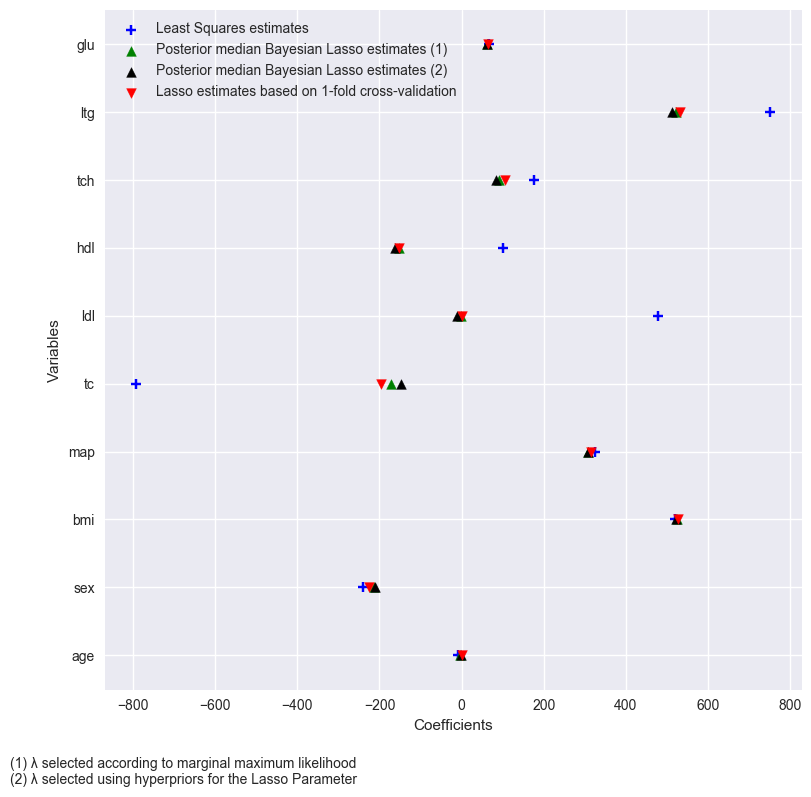

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt


df = pd.DataFrame({'variables':list(data.columns[:-1]), 'Least Squares':least_squares_coef, 'Bayesian Lasso ml':bayesian_lasso_coef_ml,'Bayesian Lasso hyp':bayesian_lasso_coef_hyp , 'CV Lasso':lasso_cv_coef})
my_range=range(1,len(df.index)+1)

plt.figure(figsize=(9,9))
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.scatter(df['Least Squares'], my_range, color='blue', alpha=1, label='Least Squares estimates', marker='+')
plt.scatter(df['Bayesian Lasso ml'], my_range, color='green', alpha=1 , label='Posterior median Bayesian Lasso estimates (1)', marker='^')
plt.scatter(df['Bayesian Lasso hyp'], my_range, color='black', alpha=1 , label='Posterior median Bayesian Lasso estimates (2)', marker='^')
plt.scatter(df['CV Lasso'], my_range, color='red', alpha=1 , label='Lasso estimates based on 3-folds cross-validation', marker='v')
plt.legend(loc=2, fontsize='medium')

# Add title and axis names
plt.yticks(my_range, df['variables'])
plt.title("", loc='center')
plt.xlabel('Coefficients')
plt.ylabel('Variables')
plt.figtext(.02, .02, "(1) λ selected according to marginal maximum likelihood\n(2) λ selected using hyperpriors for the Lasso Parameter")


## 3] Test on largest dataset

In [218]:
#train = pd.read_table('phy_train.dat', header=None)
#train = train.drop([0,80], axis = 1)
#train = train.sample(4000)
#train.index = [i for i in range(len(train))]

##### Be carefull to not have the same value in one column. It creates problem with LinAlg when using the Gibbs sampler

In [219]:
#n_unique = []
#for i in range(train.shape[1]):
#    n_unique.append(train.iloc[:,i].nunique())

In [220]:
#train = train.drop(np.where(np.array(n_unique)==1)[0]+1, axis=1)

In [ ]:
#X = train.iloc[:,1:].as_matrix()
#Y_tilde = train.iloc[:,0].ravel()

In [272]:
#np.save('predictors_large', X)
#np.save('target_large', Y_tilde)

In [222]:
X = np.load('predictors_large.npy')
Y_tilde = np.load('target_large.npy')

#### Empirical Bayes by Marginal Maximum Likelihood

#### Problem encountered in large dimension: Theory vs Implementation

We have the problem that $\sigma^2A^{-1}$ which is the covariance matrix used to generate the $\beta$'s is from the computer point of view not positive semi-definite.

Theoretically, the matrix is positive semidefinite, with several eigenvalues being exactly zero. But the computations with floating point numbers introduce truncation errors which result in some of those eigenvalues being very small but negative; hence, the matrix is not positive semidefinite.

A way to correct for the floating point errors is to add a tiny multiple of the identity matrix to the covariance matrix. I take this into account and add it in my Gibbs sampler.

In [227]:
# Correct the Gibbs sampler by adding:
        #min_eig = np.min(np.real(np.linalg.inv(A)))
        #if min_eig < 0:
        #    A -= 10*min_eig * np.eye(*A.shape)

# Between:
    #multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
# and
    #multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
    
def Gibbs_sampler(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        min_eig = np.min(np.real(np.linalg.inv(A)))
        if min_eig < 0:
            A -= 10*min_eig * np.eye(*A.shape)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return tau_sq[int(n/2):]

In [228]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [229]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [230]:
# This will be used to find the next k lambda
for i in range(30):
    if i==0:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(500, lambda_init), axis=0)))
    else:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(500, lambda_), axis=0)))
    print(lambda_)

6.9602647336
7.27216517734
7.6241616979
7.85211124699
8.06829525899
8.28208676272
8.42647257195
8.6176923363
8.71371221695
8.83116299241
8.9209440184
9.03365673596
9.02637047464
9.03445526911
9.13261958185
9.16112586041
9.18651025914
9.25203441986
9.2946898019
9.40296414438
9.48962386714
9.49750262375
9.50396384842
9.54595506547
9.49033792832
9.48083027949
9.44135592629
9.40251601429
9.40322926021
9.40907346483


In [231]:
lambda_

9.4090734648339076

#### Hyperpriors for the Lasso Parameter

Same problem as before, so I need to modify the Gibbs sampler

In [107]:
# Correct the Gibbs sampler by adding:
        #min_eig = np.min(np.real(np.linalg.inv(A)))
        #if min_eig < 0:
        #    A -= 10*min_eig * np.eye(*A.shape)

# Between:
    #multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
# and
    #multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)

In [112]:
lambda_sq_bis = Gibbs_sampler_bis(500, 2.1, 0.03)

In [113]:
np.median([np.sqrt(i) for i in lambda_sq_bis])

8.1131925601509884

We can choose the parameters $r$ and $\delta$ so that the penalty terms chosen by the two methods match. But theoretically, how to choose these 2 parameters for the second method?

## 4] Graph of the paper with larger dataset

#### Compute Bayesian lasso coefficients with corresponding lambda_ (selected according to marginal maximum likelihood)

In [279]:
bayesian_lasso_coef_ml = np.median(Gibbs_sampler_lambda(10000, lambda_), axis=0)

In [280]:
bayesian_lasso_coef_ml

array([ -4.27726232e-03,  -7.65965420e-03,  -7.11558274e-04,
         2.04720173e-01,   1.05007598e-02,  -1.25966979e-02,
         7.25181248e-03,   1.48795851e-01,   3.12771455e-02,
         3.07420493e-02,   2.40447760e-03,  -1.28578102e-02,
         2.45045527e-01,   1.78029131e-01,   1.84305323e-01,
         1.56056473e-02,   2.13972910e-02,   7.97453357e-02,
         8.98698286e-02,   7.42429244e-02,   5.86027713e-03,
        -8.09582379e-02,   5.40258284e-02,   3.92318618e-02,
         2.18409120e-02,   1.07912972e-02,   7.21017668e-05,
        -1.00228675e-02,   1.10251567e-05,   1.05557561e-02,
        -2.38035176e-02,   1.66757845e-05,   6.23721131e-04,
        -4.17405754e-02,  -6.02363424e-03,  -1.37640132e-02,
         1.66391004e-02,  -2.39596236e-02,  -1.22209411e-02,
         7.28058514e-03,  -2.01314973e-03,  -1.80244875e-03,
        -3.74549776e-04,  -1.53536691e-02,   3.16341258e-03,
         1.08739411e-02,   1.15329685e-03,  -6.24439543e-03,
         1.45550444e-02,

#### Compute Bayesian lasso coefficients with corresponding lambda_ (Hyperpriors for the Lasso Parameter)

In [282]:
bayesian_lasso_coef_hyp = np.median(Gibbs_sampler_lambda_bis(10000, 1.0001, 0.00114), axis=0)
# Before : 2.1, 0.03

In [283]:
bayesian_lasso_coef_hyp

array([ -4.19013533e-03,  -7.77192253e-03,  -7.52621845e-04,
         2.03006104e-01,   1.08717010e-02,  -1.24697547e-02,
         7.84902289e-03,   1.49472684e-01,   3.18054418e-02,
         3.03789467e-02,   2.42198904e-03,  -1.30742623e-02,
         2.44556013e-01,   1.77443646e-01,   1.80497665e-01,
         1.55244158e-02,   2.38321734e-02,   7.71155951e-02,
         8.95066484e-02,   7.50423978e-02,   5.95112104e-03,
        -8.10534496e-02,   5.28265312e-02,   3.85454319e-02,
         2.20225498e-02,   9.93400725e-03,  -1.86278295e-03,
        -9.47186310e-03,   1.08425289e-05,   9.26951434e-03,
        -2.42591952e-02,   1.65755730e-05,   6.64616464e-04,
        -3.68177453e-02,  -5.74610067e-03,  -1.32785793e-02,
         1.59001945e-02,  -2.35855973e-02,  -1.26149643e-02,
         6.95383651e-03,  -1.16814097e-03,  -2.67591193e-03,
         3.57732806e-04,  -1.37720366e-02,   3.33600105e-03,
         1.01523678e-02,  -6.08548483e-04,  -4.78074453e-03,
         1.36570095e-02,

#### Lasso estimates based on n-fold cross validation

In [284]:
from sklearn import linear_model
lasso = linear_model.LassoCV()
lasso.fit(X, Y_tilde)

# The estimator chose automatically its lambda:
lasso_cv_coef = lasso.coef_

/Users/Linger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Linger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### Estimates of ordinary least squares

In [288]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)
least_squares_coef = lm.coef_

In [289]:
%matplotlib inline
import matplotlib.pyplot as plt


df = pd.DataFrame({'variables':list(train.columns[1:]), 'Least Squares':least_squares_coef, 'Bayesian Lasso ml':bayesian_lasso_coef_ml,'Bayesian Lasso hyp':bayesian_lasso_coef_hyp , 'CV Lasso':lasso_cv_coef})
df.variables = [i+1 for i in range(len(df))]
my_range=range(1,len(df.index)+1)

ValueError: arrays must all be same length

#### Graph

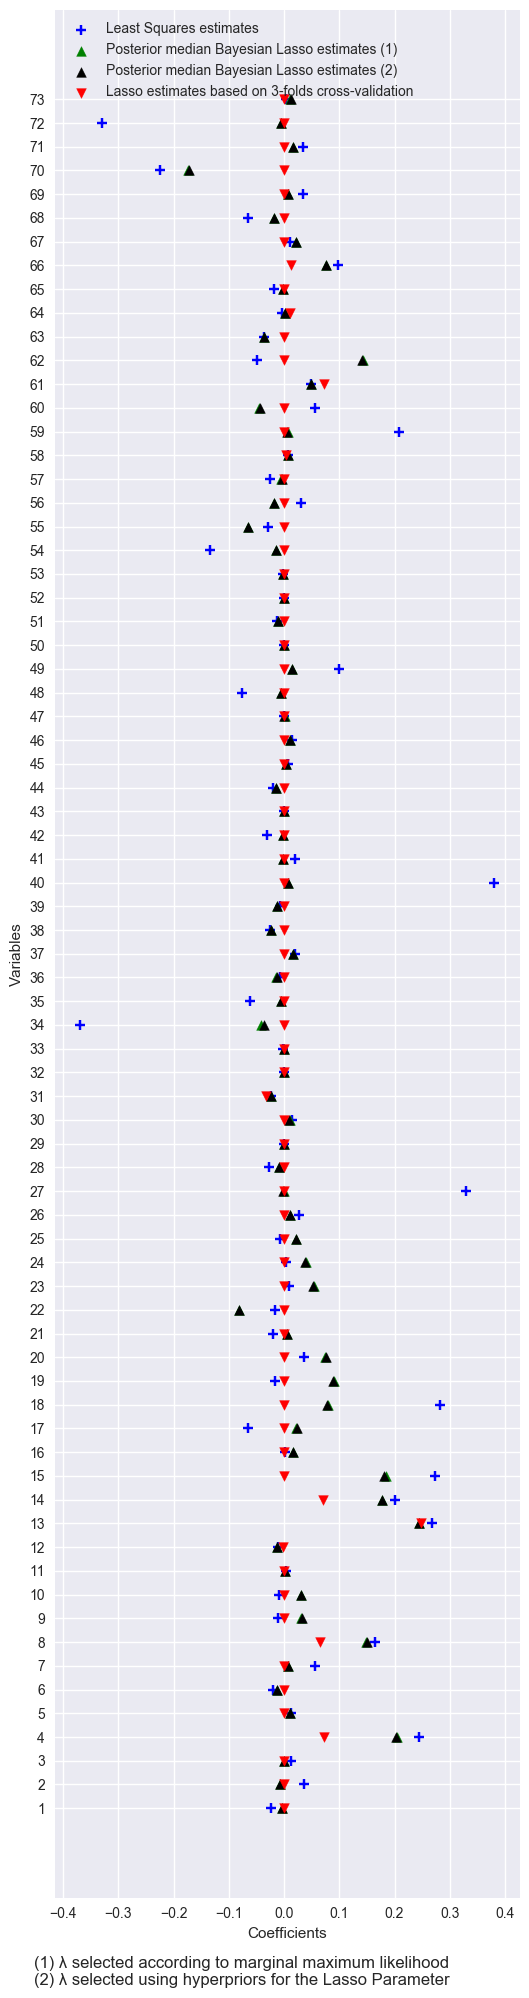

In [290]:
%matplotlib inline
import matplotlib.pyplot as plt


df = pd.DataFrame({'variables':[i for i in range(X.shape[1])], 'Least Squares':least_squares_coef, 'Bayesian Lasso ml':bayesian_lasso_coef_ml,'Bayesian Lasso hyp':bayesian_lasso_coef_hyp , 'CV Lasso':lasso_cv_coef})
df.variables = [i+1 for i in range(len(df))]
my_range=range(1,len(df.index)+1)

plt.figure(figsize=(6,25))
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.scatter(df['Least Squares'], my_range, color='blue', alpha=1, label='Least Squares estimates', marker='+')
plt.scatter(df['Bayesian Lasso ml'], my_range, color='green', alpha=1 , label='Posterior median Bayesian Lasso estimates (1)', marker='^')
plt.scatter(df['Bayesian Lasso hyp'], my_range, color='black', alpha=1 , label='Posterior median Bayesian Lasso estimates (2)', marker='^')
plt.scatter(df['CV Lasso'], my_range, color='red', alpha=1 , label='Lasso estimates based on 3-folds cross-validation', marker='v')
plt.legend(loc=2, fontsize='small')

# Add title and axis names
plt.yticks(my_range, df['variables'])
plt.title("", loc='center')
plt.xlabel('Coefficients')
plt.ylabel('Variables')
plt.figtext(0.09, 0.09, "(1) λ selected according to marginal maximum likelihood\n(2) λ selected using hyperpriors for the Lasso Parameter")

# 5] Analysis of the Empirical Bayes by Marginal Maximum Likelihood method

#### On the diabete data

In [173]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [174]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

How does the number of examples in the Gibbs sampler impact the convergence of the algorithm?

We count the number of iterations we need to reach a lambda equal to 0.237+-0.01, with different n used in the Gibbs sampler.

In [239]:
# This will be used to find the next k lambda
n = [j for j in range(10,1300,300)]
lambda_list_of_list = []
for j in n:
    lambda_list = []
    for i in range(30):
        if i==0:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_init), axis=0)))
        else:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_), axis=0)))
        lambda_list.append(lambda_)
    print(j)
    lambda_list_of_list.append(lambda_list)

10
310
610
910
1210


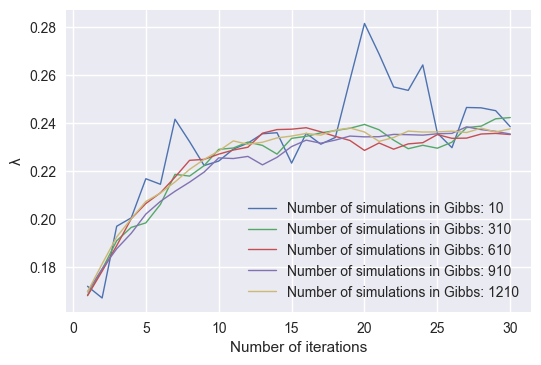

In [242]:
dict_df = {"{}".format(n[i]):lambda_list_of_list[i] for i in range(len(n))}
dict_df.update({'x': range(1,31)})

df = pd.DataFrame(dict_df)

# multiple line plot
for i in n:
    plt.plot( 'x', '{}'.format(i), data=df, linewidth=1, label = 'Number of simulations in Gibbs: {}'.format(i))

plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('λ')

We can see here that it is useless to use a number of simulated observations greater than 500, for the Gibbs sampler.

#### Same on my high dimensional dataset

In [248]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [249]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [250]:
# This will be used to find the next k lambda
n = [j for j in range(10,1300,300)]
lambda_list_of_list = []
for j in n:
    lambda_list = []
    for i in range(30):
        if i==0:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_init), axis=0)))
        else:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_), axis=0)))
        lambda_list.append(lambda_)
    print(j)
    lambda_list_of_list.append(lambda_list)

10
310
610
910
1210


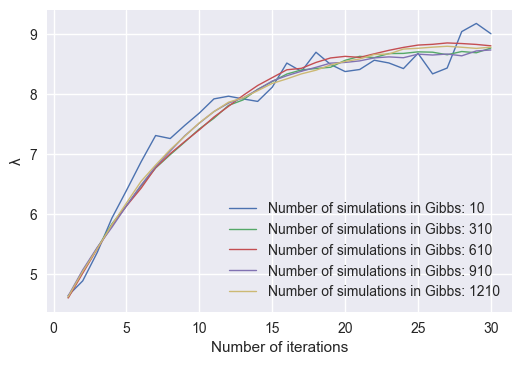

In [251]:
dict_df = {"{}".format(n[i]):lambda_list_of_list[i] for i in range(len(n))}
dict_df.update({'x': range(1,31)})

df = pd.DataFrame(dict_df)

# multiple line plot
for i in n:
    plt.plot( 'x', '{}'.format(i), data=df, linewidth=1, label = 'Number of simulations in Gibbs: {}'.format(i))

plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('λ')

Again here, around 500 simulations for Gibbs seems a good choice.

Now, we are going to plot the evolution of 50 lambda found using 500 simulations for Gibbs. To see when the lambda are stable.

#### On diabete data

In [289]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [290]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [291]:
lambda_list = []
for i in range(50):
    if i==0:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(500, lambda_init), axis=0)))
    else:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(500, lambda_), axis=0)))
    print(i)
    lambda_list.append(lambda_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


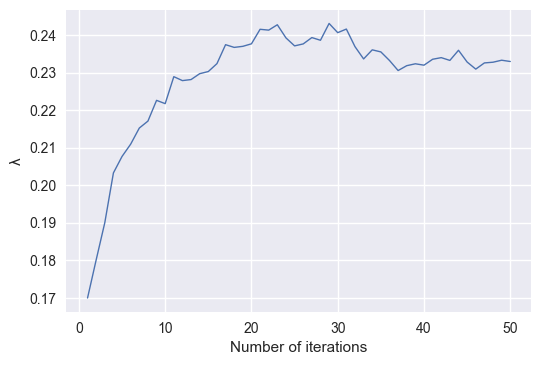

In [292]:
dict_df = {'x': range(1,51), 'λ':lambda_list}
df = pd.DataFrame(dict_df)

plt.plot( 'x', 'λ', data=df, linewidth=1)

plt.xlabel('Number of iterations')
plt.ylabel('λ')

After 15-20 iterations the lambda seem stable.

#### Same on my high dimensional dataset

In [280]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [281]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [282]:
lambda_list = []
for i in range(50):
    if i==0:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(500, lambda_init), axis=0)))
    else:
        lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(500, lambda_), axis=0)))
    print(i)
    lambda_list.append(lambda_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


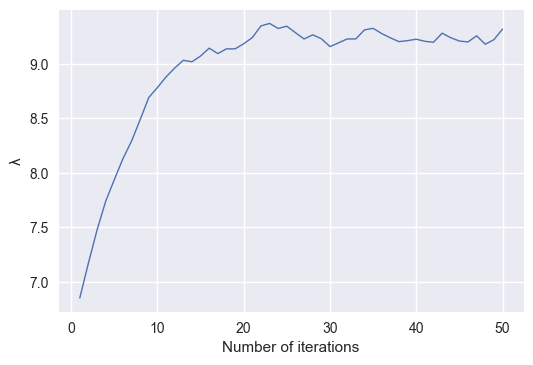

In [284]:
dict_df = {'x': range(1,51), 'λ':lambda_list}
df = pd.DataFrame(dict_df)

plt.plot( 'x', 'λ', data=df, linewidth=1)


plt.xlabel('Number of iterations')
plt.ylabel('λ')

Again here, around 15-20 iterations are sufficient to get a stable lambda.

But does the variance of lambda depend on the number of iterations introduced in Gibbs?

#### On diabete data

In [328]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [329]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [347]:
simul = [10, 50, 200, 500, 1000]
var_list_list = []
for j in simul:
    var_list = []
    lambda_list = []
    for i in range(50):
        if i==0:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_init), axis=0)))
        else:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_), axis=0)))
        lambda_list.append(lambda_)
        var_list.append(np.var(lambda_list))
    var_list_list.append(var_list)
    print(j)

10
50
200
500
1000


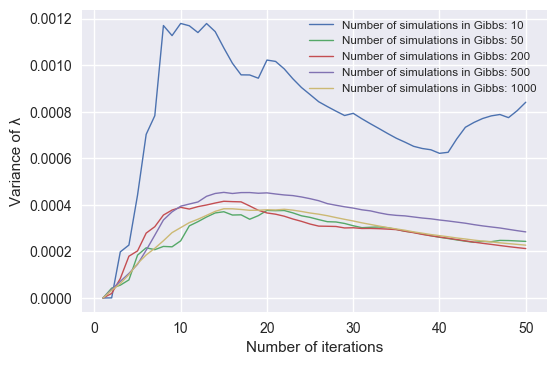

In [348]:
dict_df = {"{}".format(simul[i]):var_list_list[i] for i in range(len(simul))}
dict_df.update({'x': range(1,51)})

df = pd.DataFrame(dict_df)

# multiple line plot
for i in simul:
    plt.plot( 'x', '{}'.format(i), data=df, linewidth=1, label = 'Number of simulations in Gibbs: {}'.format(i))

plt.legend(fontsize='small')
plt.xlabel('Number of iterations')
plt.ylabel('Variance of λ')

#### On larger dataset

In [354]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [355]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [356]:
simul = [10, 50, 200, 500, 1000]
var_list_list = []
for j in simul:
    var_list = []
    lambda_list = []
    for i in range(50):
        if i==0:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_init), axis=0)))
        else:
            lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(j, lambda_), axis=0)))
        lambda_list.append(lambda_)
        var_list.append(np.var(lambda_list))
    var_list_list.append(var_list)
    print(j)

10
50
200
500
1000


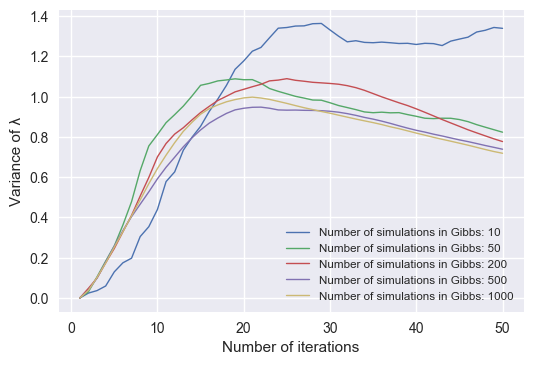

In [378]:
dict_df = {"{}".format(simul[i]):var_list_list[i] for i in range(len(simul))}
dict_df.update({'x': range(1,51)})

df = pd.DataFrame(dict_df)

# multiple line plot
for i in simul:
    plt.plot( 'x', '{}'.format(i), data=df, linewidth=1, label = 'Number of simulations in Gibbs: {}'.format(i))

plt.legend(fontsize='small')
plt.xlabel('Number of iterations')
plt.ylabel('Variance of λ')

# 6] Analysis of the Hyperpriors for the Lasso Parameter method

#### On diabete data

Value of the posterior median for lambda, depending on the number of simulations considered in Gibbs.

In [418]:
lambda_sq_bis = Gibbs_sampler_bis(1300, 1, 1.78)

In [419]:
n = [j for j in range(10,100,10)] + [300, 1000]
list_lambda = []
for j in n:
    list_lambda.append(np.median([np.sqrt(i) for i in lambda_sq_bis[:j]]))

In [420]:
pd.DataFrame({'Number of simulations in Gibbs': n, 'λ': list_lambda})

,Number of simulations in Gibbs,λ
0,10,0.296845
1,20,0.236998
2,30,0.240264
3,40,0.283050
4,50,0.283050
5,60,0.266630
6,70,0.282465
7,80,0.268880
8,90,0.279587
9,300,0.267241


Since we take the median of the simulations and not the mean, we do not need a high number of simulations in Gibbs to get a good value of lambda.

#### On larger data

In [405]:
lambda_sq_bis = Gibbs_sampler_bis(1300, 2.1, 0.03)

In [412]:
n = [j for j in range(10,100,10)] + [300, 1000]
list_lambda = []
for j in n:
    list_lambda.append(np.median([np.sqrt(i) for i in lambda_sq_bis[:j]]))

In [413]:
pd.DataFrame({'Number of simulations in Gibbs': n, 'λ': list_lambda})

,Number of simulations in Gibbs,λ
0,10,2.830716
1,20,5.316183
2,30,5.916011
3,40,6.937073
4,50,8.166762
5,60,8.290933
6,70,8.284278
7,80,8.275830
8,90,8.249092
9,300,8.049158


Same remark here, we do not need a high number of simulations in Gibbs to get stable value of lambda.

Now, we are going to see how does the 2 parameters $r$ and $\delta$ impact the Gibbs sampler when put hyperprior on $\lambda$.

In the paper, it is said that we want the prior density for $\lambda^2$ to approach 0 sufficiently fast as $\lambda^2 \rightarrow \infty$ (to avoid mixing problems) and to be relatively flat and place high probability near the maximum likelihood estimate. 

In [18]:
from scipy.special import gamma
def gamma_prior_lambda_sq(lambda_sq, r, delta):
    return ((delta**r)/gamma(r))*(lambda_sq)**(r-1)*np.exp(-delta*lambda_sq)

r --> 1 
 delta --> 1


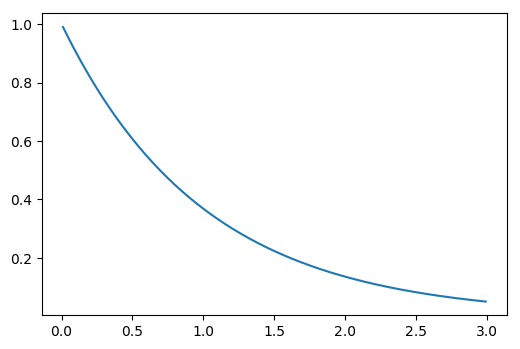

r --> 3 
 delta --> 1


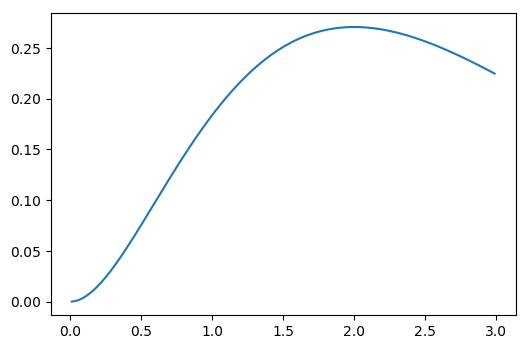

r --> 5 
 delta --> 1


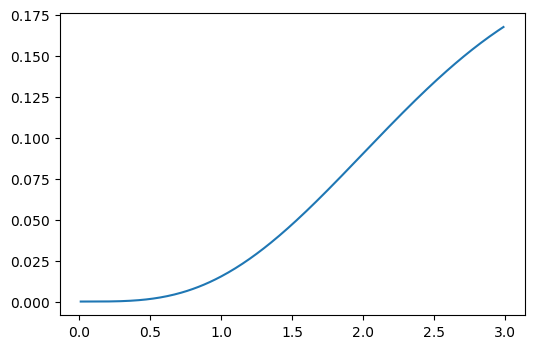

r --> 7 
 delta --> 1


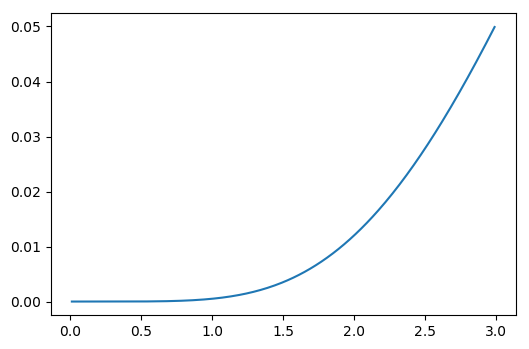

r --> 9 
 delta --> 1


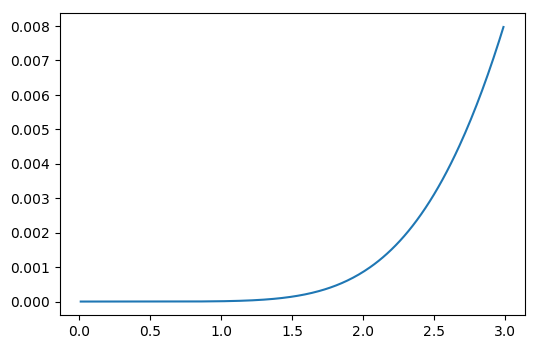

r --> 1 
 delta --> 3


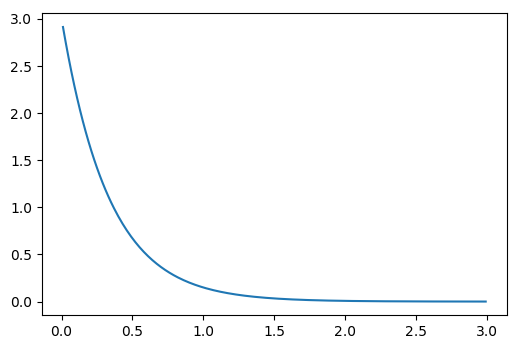

r --> 3 
 delta --> 3


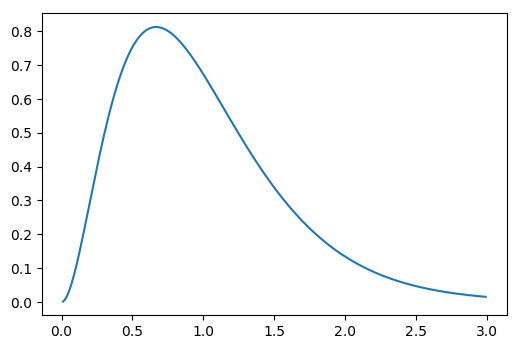

r --> 5 
 delta --> 3


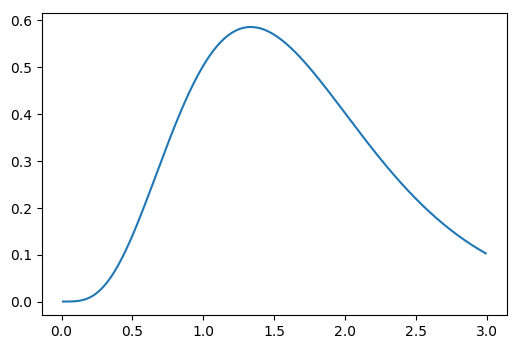

r --> 7 
 delta --> 3


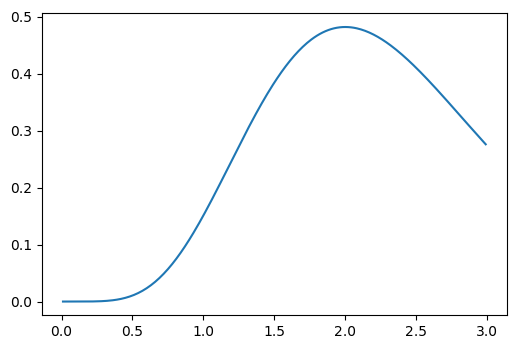

r --> 9 
 delta --> 3


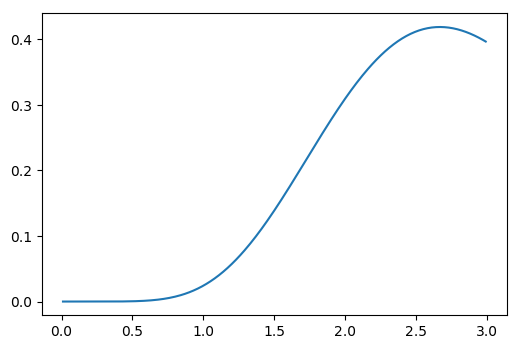

r --> 1 
 delta --> 5


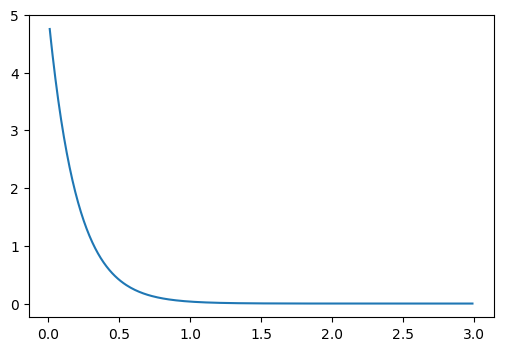

r --> 3 
 delta --> 5


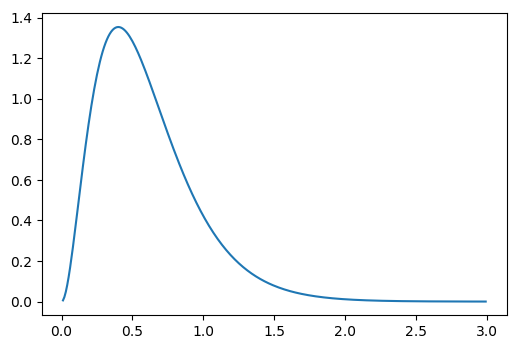

r --> 5 
 delta --> 5


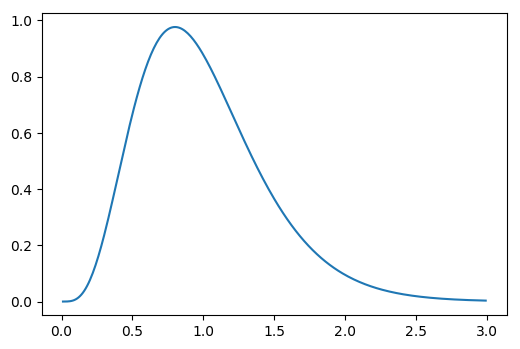

r --> 7 
 delta --> 5


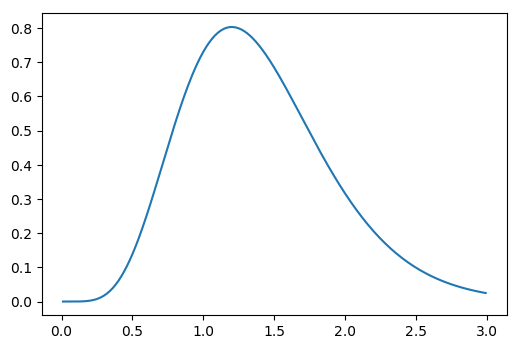

r --> 9 
 delta --> 5


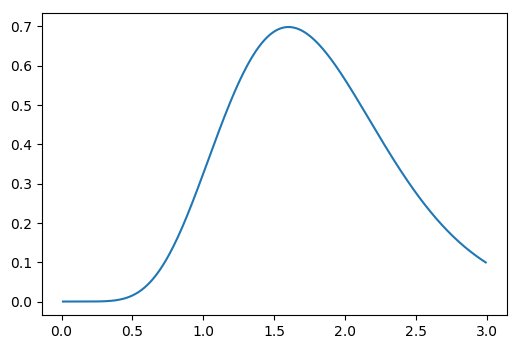

r --> 1 
 delta --> 7


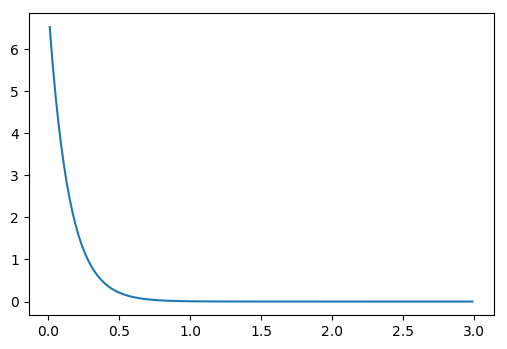

r --> 3 
 delta --> 7


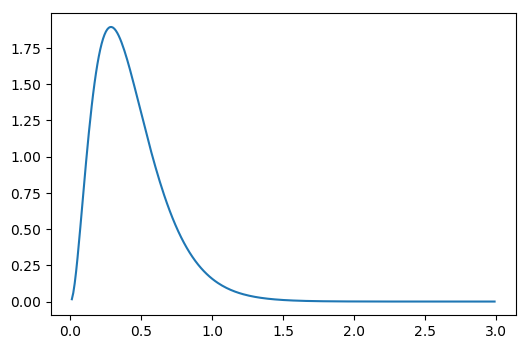

r --> 5 
 delta --> 7


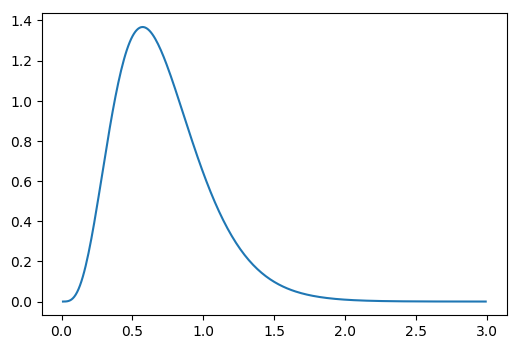

r --> 7 
 delta --> 7


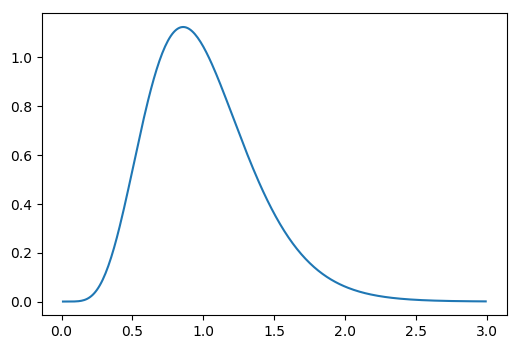

r --> 9 
 delta --> 7


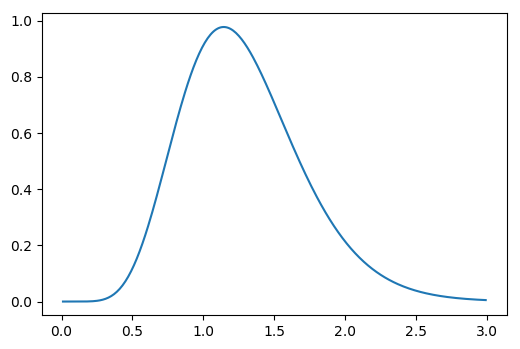

r --> 1 
 delta --> 9


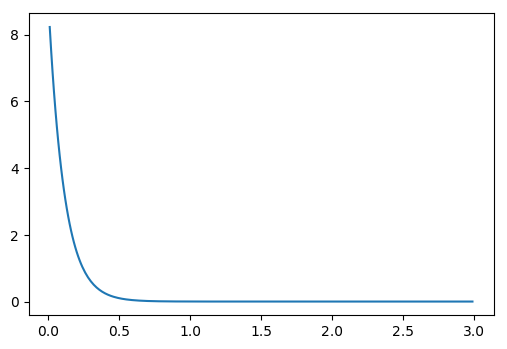

r --> 3 
 delta --> 9


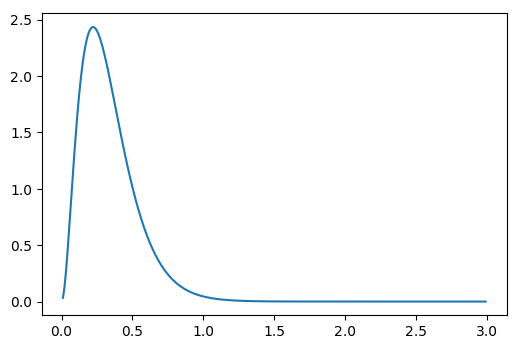

r --> 5 
 delta --> 9


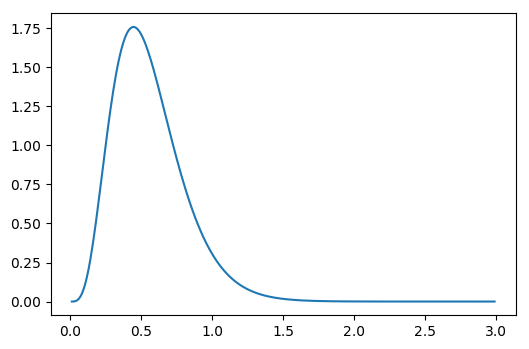

r --> 7 
 delta --> 9


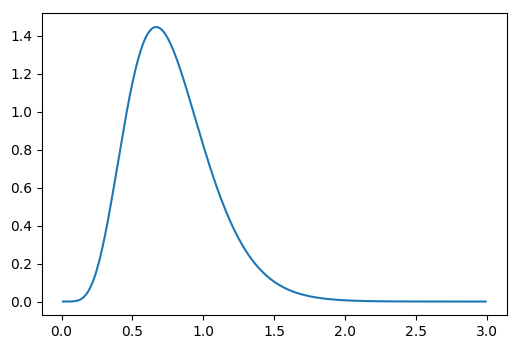

r --> 9 
 delta --> 9


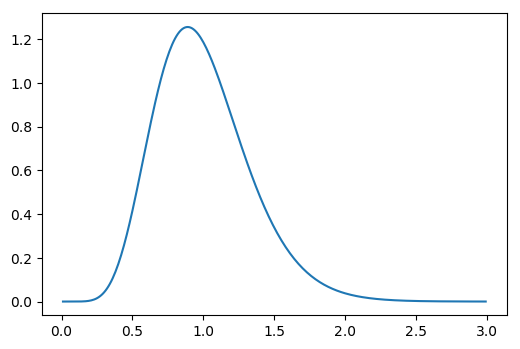

r --> 1 
 delta --> 11


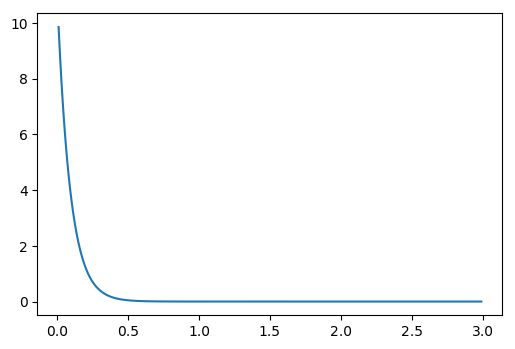

r --> 3 
 delta --> 11


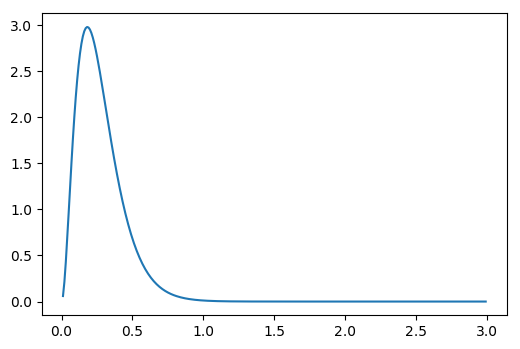

r --> 5 
 delta --> 11


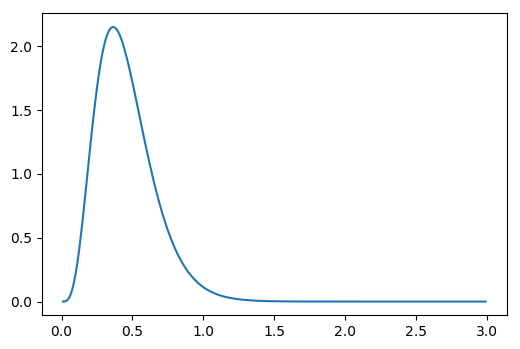

r --> 7 
 delta --> 11


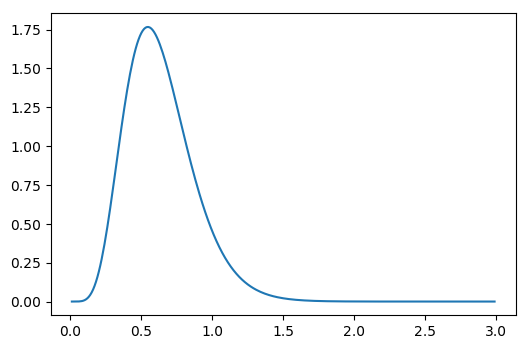

r --> 9 
 delta --> 11


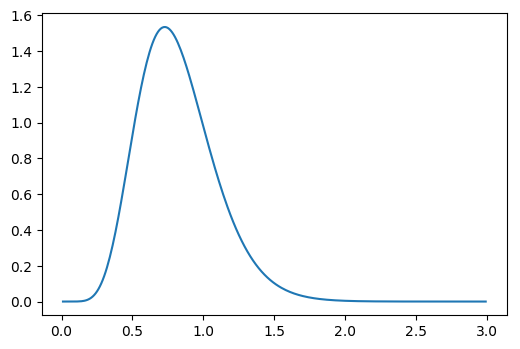

r --> 1 
 delta --> 13


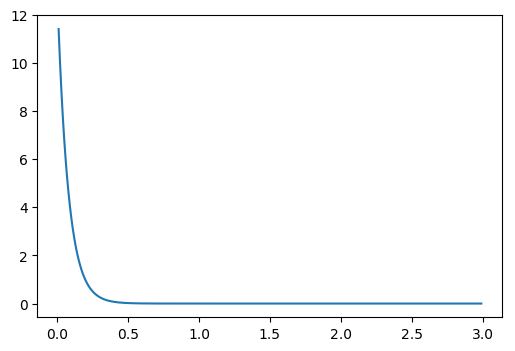

r --> 3 
 delta --> 13


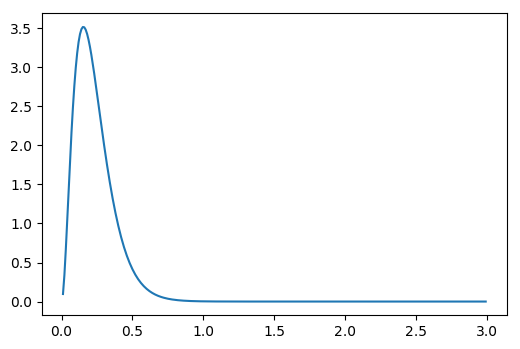

r --> 5 
 delta --> 13


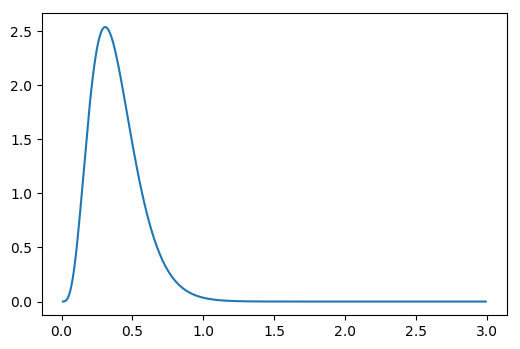

r --> 7 
 delta --> 13


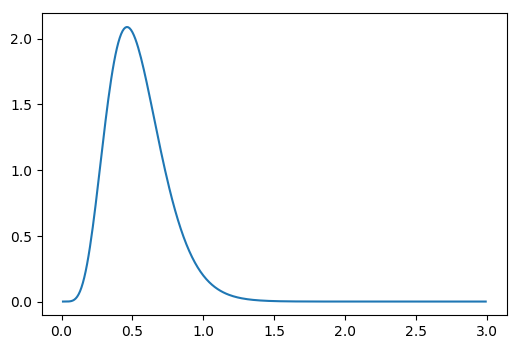

r --> 9 
 delta --> 13


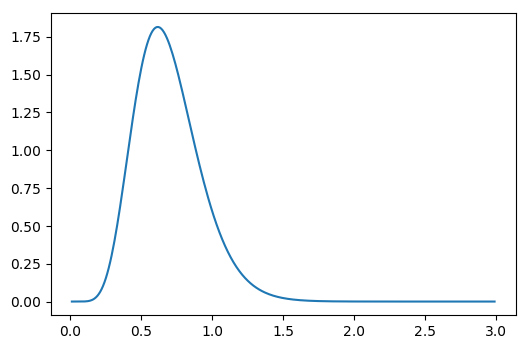

r --> 1 
 delta --> 15


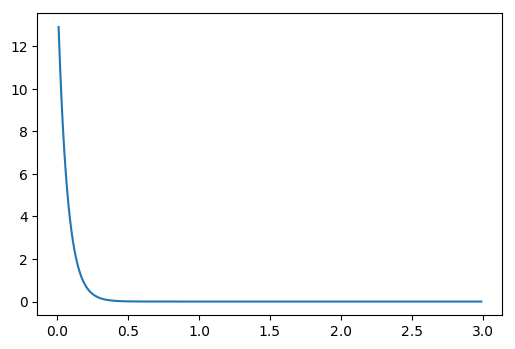

r --> 3 
 delta --> 15


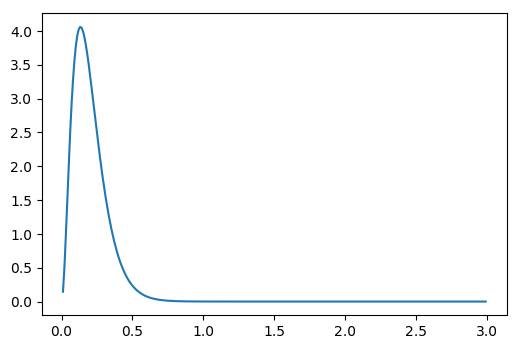

r --> 5 
 delta --> 15


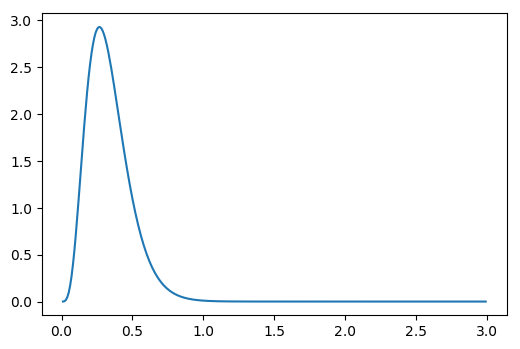

r --> 7 
 delta --> 15


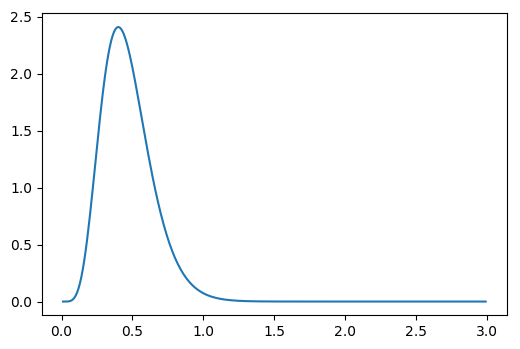

r --> 9 
 delta --> 15


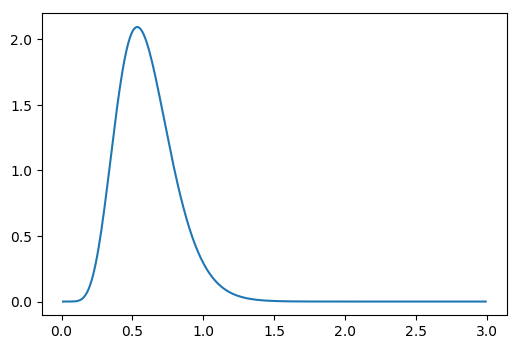

r --> 1 
 delta --> 17


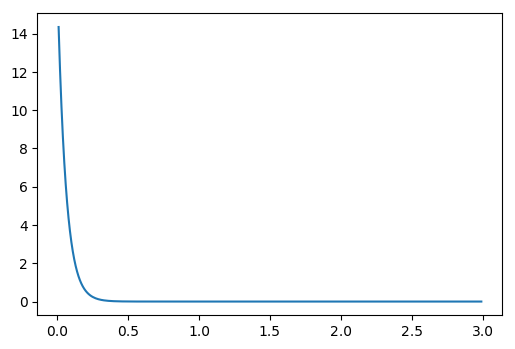

r --> 3 
 delta --> 17


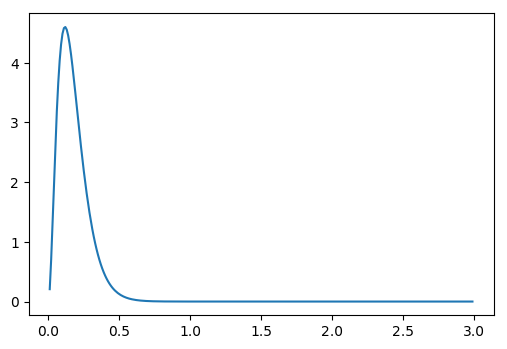

r --> 5 
 delta --> 17


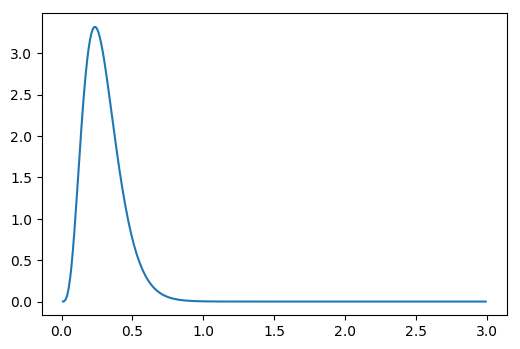

r --> 7 
 delta --> 17


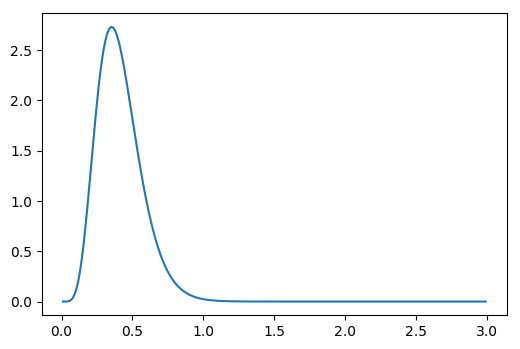

r --> 9 
 delta --> 17


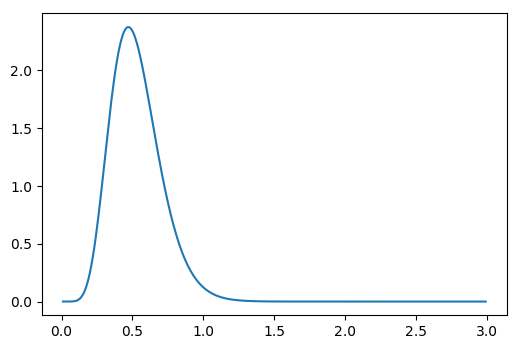

r --> 1 
 delta --> 19


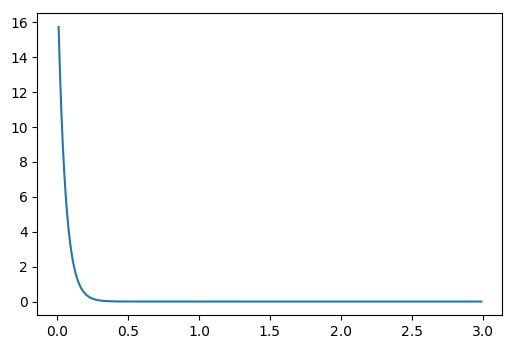

r --> 3 
 delta --> 19


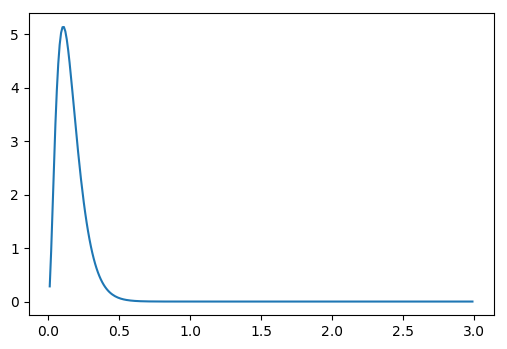

r --> 5 
 delta --> 19


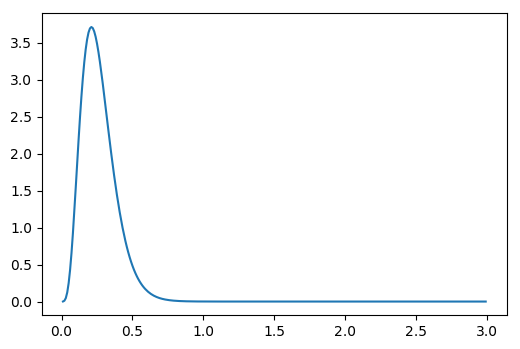

r --> 7 
 delta --> 19


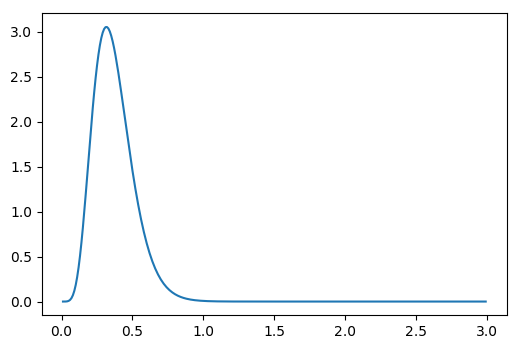

r --> 9 
 delta --> 19


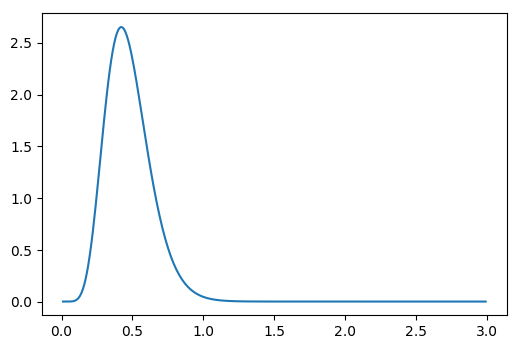

In [79]:
# Plot for different values of r and lambda
for i in range(1,20,2):
    for j in range(1,10,2):
        print('r --> {} \n delta --> {}'.format(j,i))
        plt.plot([k/100 for k in range(1,300,1)], [gamma_prior_lambda_sq(k/100, j, i) for k in range(1,300,1)])
        plt.show()

The higher the $\delta$, the sharper the distribution, the higher the $r$, the more to the right the spike of the distribution (mean shifted to the right).

r --> 0.3 
 delta --> 1.3


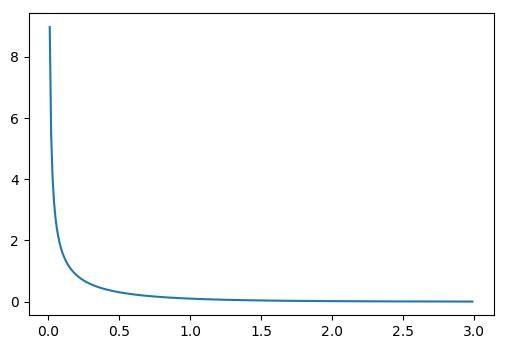

r --> 0.6 
 delta --> 1.3


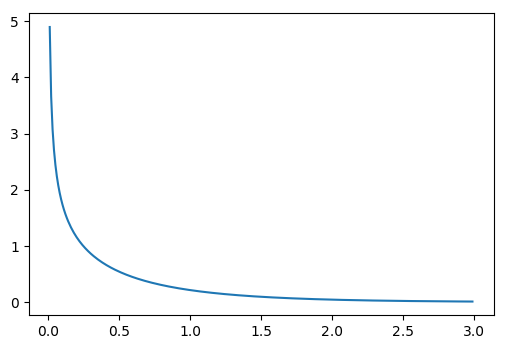

r --> 0.7 
 delta --> 1.3


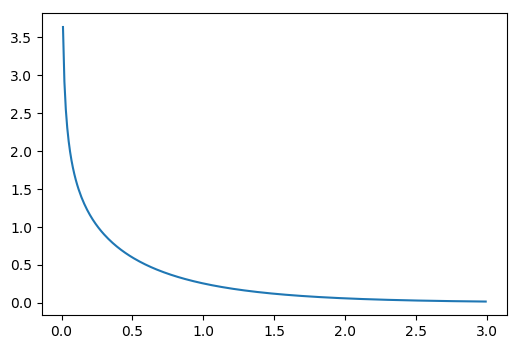

r --> 1 
 delta --> 1.3


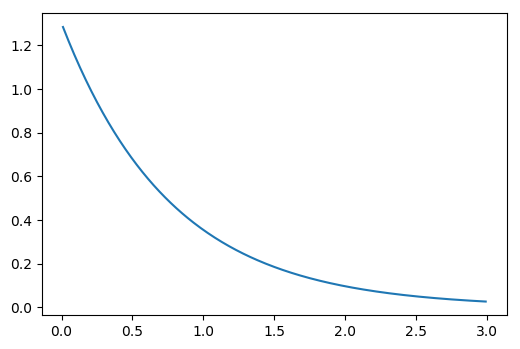

r --> 1.2 
 delta --> 1.3


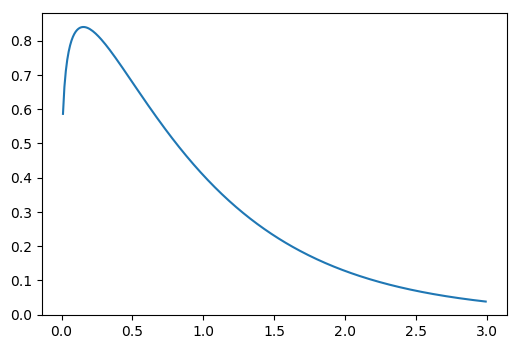

r --> 1.4 
 delta --> 1.3


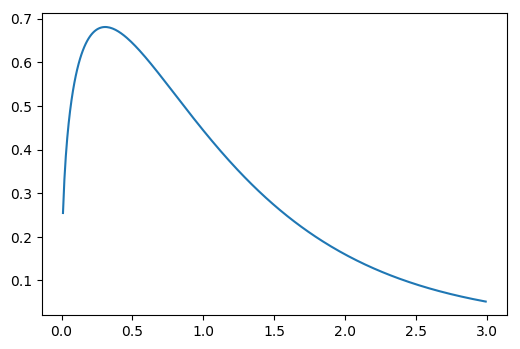

r --> 0.3 
 delta --> 1.5


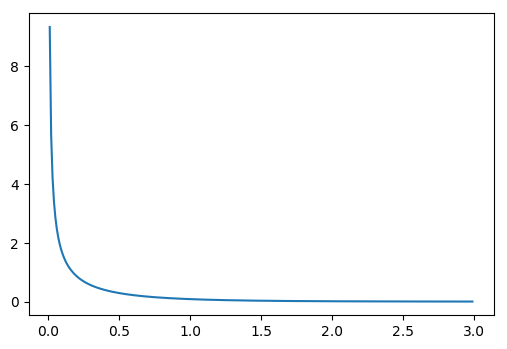

r --> 0.6 
 delta --> 1.5


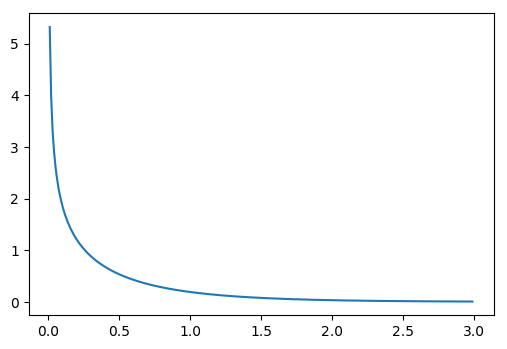

r --> 0.7 
 delta --> 1.5


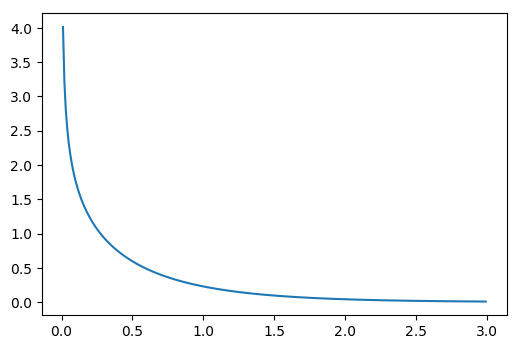

r --> 1 
 delta --> 1.5


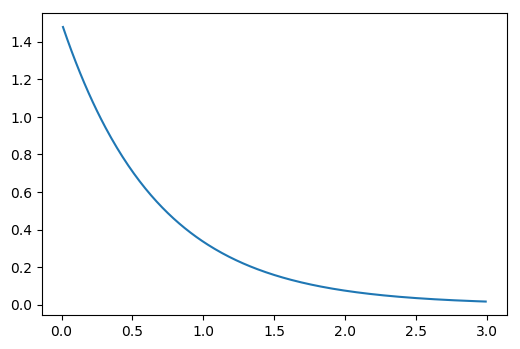

r --> 1.2 
 delta --> 1.5


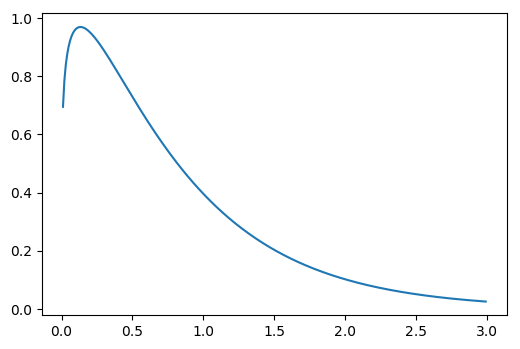

r --> 1.4 
 delta --> 1.5


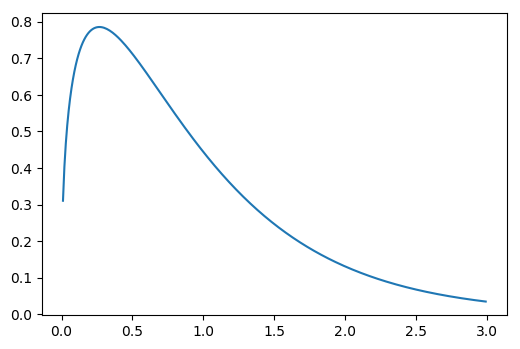

r --> 0.3 
 delta --> 1.78


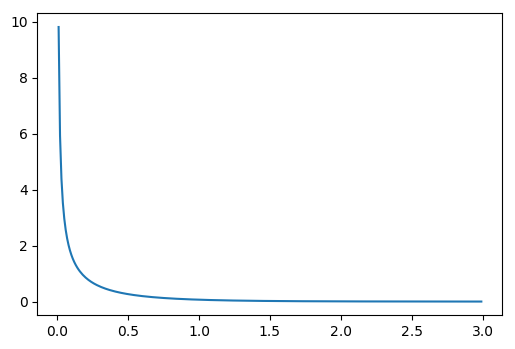

r --> 0.6 
 delta --> 1.78


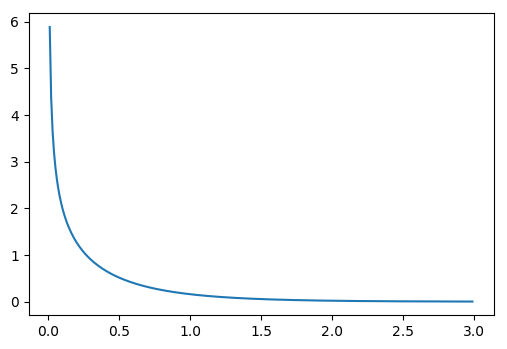

r --> 0.7 
 delta --> 1.78


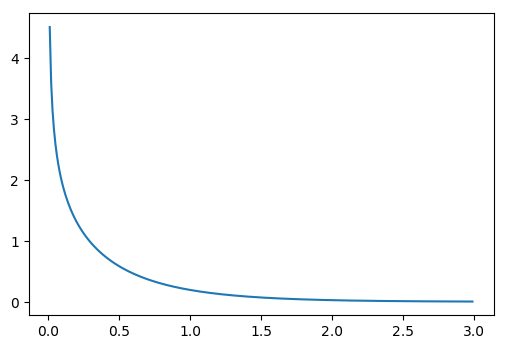

r --> 1 
 delta --> 1.78


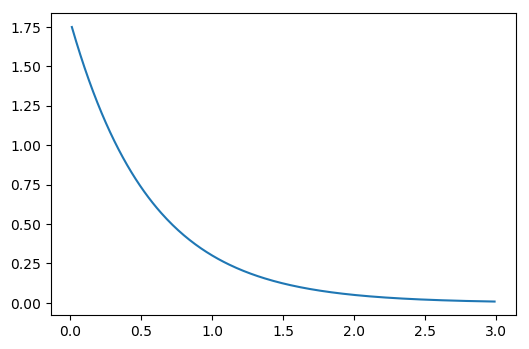

r --> 1.2 
 delta --> 1.78


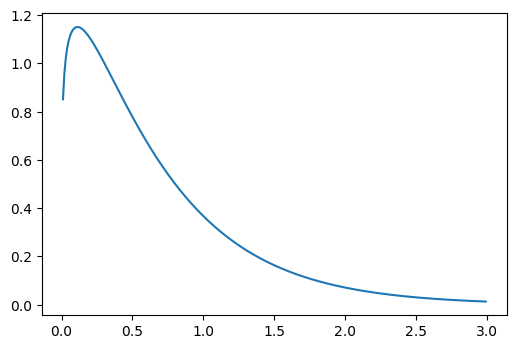

r --> 1.4 
 delta --> 1.78


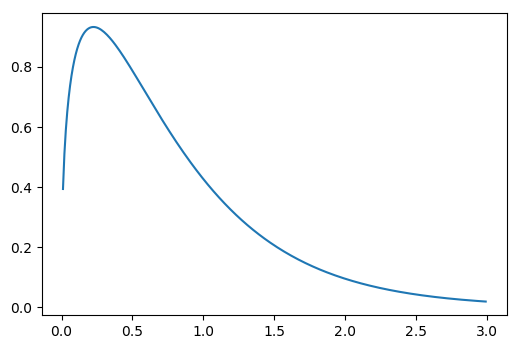

r --> 0.3 
 delta --> 1.9


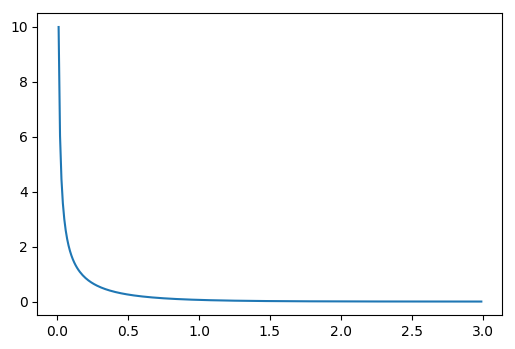

r --> 0.6 
 delta --> 1.9


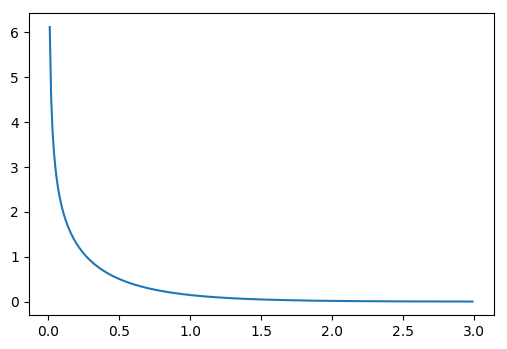

r --> 0.7 
 delta --> 1.9


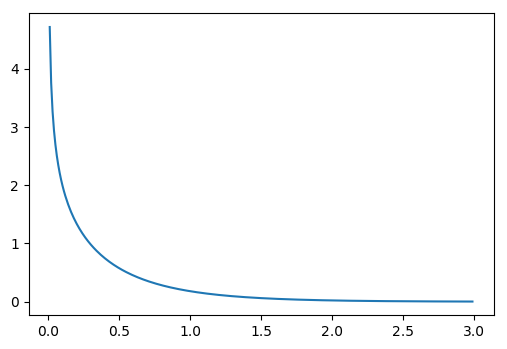

r --> 1 
 delta --> 1.9


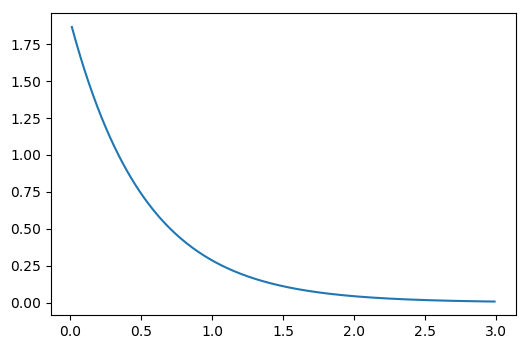

r --> 1.2 
 delta --> 1.9


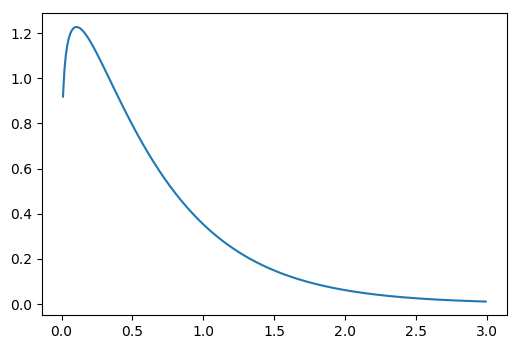

r --> 1.4 
 delta --> 1.9


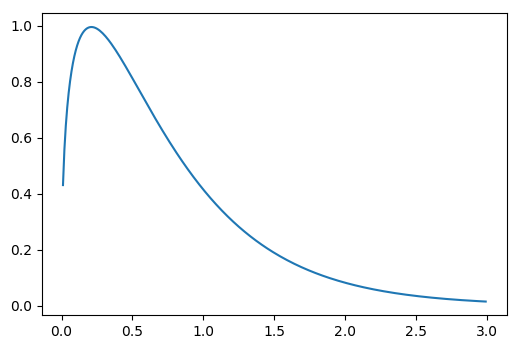

r --> 0.3 
 delta --> 2


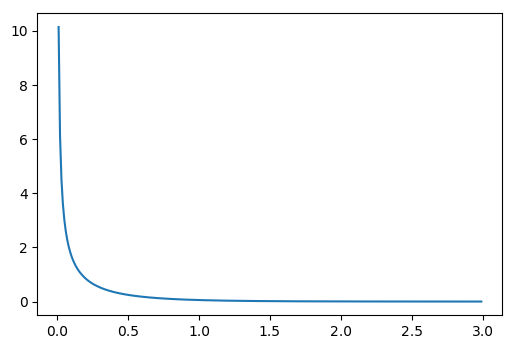

r --> 0.6 
 delta --> 2


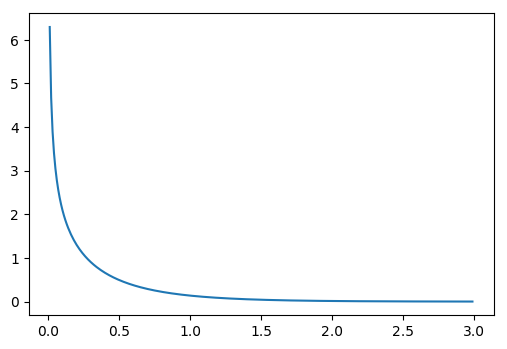

r --> 0.7 
 delta --> 2


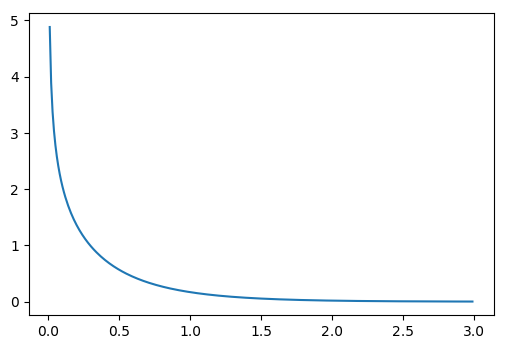

r --> 1 
 delta --> 2


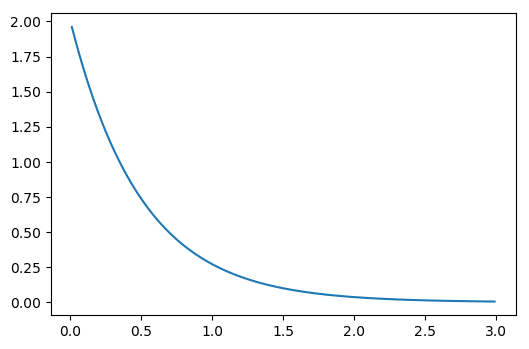

r --> 1.2 
 delta --> 2


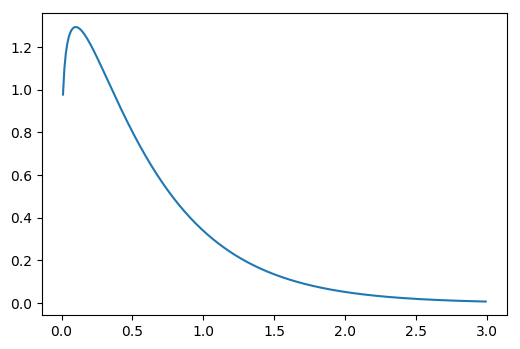

r --> 1.4 
 delta --> 2


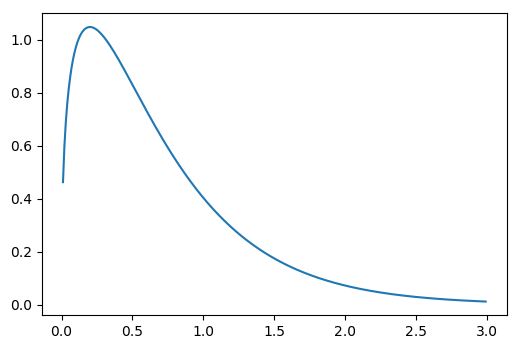

In [80]:
# Plot for different values of r and lambda
for i in [1.3,1.5,1.78,1.9,2]:
    for j in [.3,.6,.7,1,1.2,1.4]:
        print('r --> {} \n delta --> {}'.format(j,i))
        plt.plot([k/100 for k in range(1,300,1)], [gamma_prior_lambda_sq(k/100, j, i) for k in range(1,300,1)])
        plt.show()

In [99]:
proba = np.array([gamma_prior_lambda_sq(k/100, 1, 1.78) for k in range(1,300,1)])
evaluation_points = np.array([k/100 for k in range(1,300,1)])

In [103]:
# Mean of lambda**2
np.sum(proba*0.01*evaluation_points)

0.54457263970268988

In [105]:
# Equal to 10 times the maximum likelihood estimate
.237*.237*10

0.56169

Indeed, the prior on $\lambda^2$ is exponential with mean equal to about 10 times the maximum likelihood estimate.

On larger data, how should we set the parameters $r$ and $\delta$ of the gamma prior on $\lambda^2$?

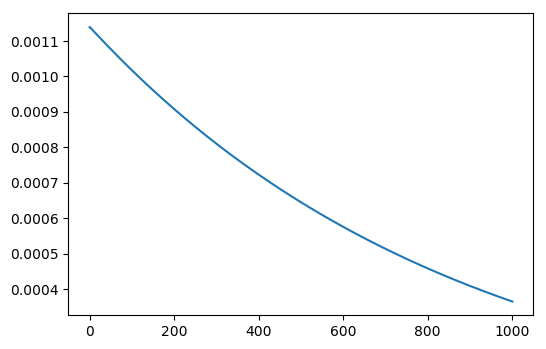

In [253]:
r = 1.0001
delta = 0.00114
plt.plot([k/100 for k in range(1,100000,1)], [gamma_prior_lambda_sq(k/100, r, delta) for k in range(1,100000,1)])

In [254]:
proba = np.array([gamma_prior_lambda_sq(k/100, r, delta) for k in range(1,1000000,1)])
evaluation_points = np.array([k/100 for k in range(1,1000000,1)])
# Mean of lambda**2
np.sum(proba*0.01*evaluation_points)

877.15888792633268

In [235]:
# Equal to 10 times the maximum likelihood estimate
lambda_*lambda_*10

885.30663466641556

In [255]:
lambda_sq_bis = Gibbs_sampler_bis(1000, 1.0001, 0.00114)
np.median([np.sqrt(i) for i in lambda_sq_bis])

9.2665818686636552